In [1]:
import os
import sys
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score 

# We need to be able to access the files/directories outside of the `Notebooks` directory.
sys.path.append(os.path.abspath(os.path.join("..")))

from pvsnp import analysis_utils as au
from pvsnp import visualize

from pvsnp import place_cell_analysis
from pvsnp.resampling import Resampler

from pvsnp import clustering
from pvsnp.graph_analysis import NeuronNetwork

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

#### We load & preprocess the neural data from an experiment.

In [3]:
s = pd.read_csv("data/artificial_epm_s.csv", header=0)
c = pd.read_csv("data/artificial_epm_c.csv", header=0)
behavior = pd.read_csv("data/epm_behavior.csv", header=0)

# For convenience, cast every column name to an int.
s.columns = [int(col) for col in s.columns]
c.columns = [int(col) for col in c.columns]

behavior_column_names = ['X',
                         'Y',
                         'Area',
                         'Areachange',
                         'Elongation',
                         'Distance_moved',
                         'Velocity',
                         'Arena_centerpoint',
                         'Open1',
                         'Open2',
                         'Closed1',
                         'Closed2',
                         'OpenArms',
                         'ClosedArms'
                        ]

# Drop every 3rd row from the behavior dataframe
# behavior = downsample_dataframe(behavior, 3)

# Rename the behavior dataframe columns and drop all useless column vectors.
behavior.columns = behavior_column_names
# behavior.drop(["Hardware1, "Hardware2", "Hardware3", "Hardware4", "Result_1"], axis=1, inplace=True)

# We add a time series column using Timedelta, where the amount of periods is the current
# total amount of frames in the dataframe. 10 fps implies 100 milliseconds (ms) per frame, 
# so we set each period to be 100 ms long.
behavior = behavior.assign(Trial_time=pd.timedelta_range(0, periods=len(behavior.index), freq="100ms"))

# Create a Mouse object to store all of the data for a particular mouse
mickey = au.Mouse(name="Mickey", age=1, sex='M', cell_transients=c, spikes=s, behavior=behavior)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
# mickey.spikes = mickey.spikes.where(mickey.spikes==0, 1)

# Add "Center" column to concatenated dataframe
center = (mickey.spikes_and_beh["OpenArms"]) + (mickey.spikes_and_beh["ClosedArms"])
center = 1 - center
mickey.spikes_and_beh["Center"] = center

## Heatmaps

#### Plot a heatmap and a "true" scatterplot for a single neuron.
#### Note: The heatmap below does *not* take "time spent in bins" or anything else into account. 

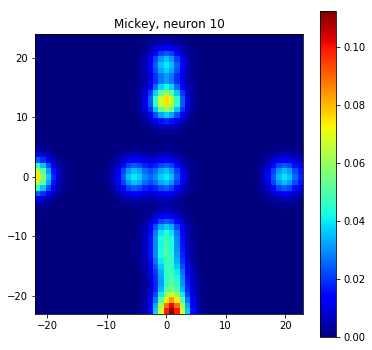

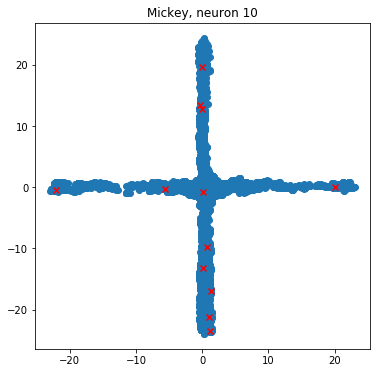

In [4]:
neuron = 10

# Make a copy of the coordinate Series in order to preserve the original data.
x_coords = mickey.spikes_and_beh["X"].copy()
y_coords = mickey.spikes_and_beh["Y"].copy()

x = x_coords.astype(int)
y = y_coords.astype(int)

# We need to create a vector of boolean values for when the (provided) neuron 
# fired and didn't fire. This is passed to the plot_heatmap function in order 
# to only create a heatmap based on where the neuron fired. 
weights = (mickey.spikes_and_beh[neuron] != 0).astype(int)
weights = pd.Series(weights)

title = "{}, neuron {}".format(mickey.name, neuron)

visualize.plot_heatmap(x, y, sigma=2, title=title, bins=50, figsize=(6, 6), weights=weights, savefig=False);

# -----------------------

# Now, we plot a scatterplot to compare the heatmap with the precise firing positions of the neuron. 

plt.figure(figsize=(6, 6));
plt.scatter(x_coords, y_coords, marker='o');

# Get the coordinates where the neuron actually fired.
x_1 = x_coords.loc[mickey.spikes_and_beh[neuron] != 0]
y_1 = y_coords.loc[mickey.spikes_and_beh[neuron] != 0]

# Overlay the first scatterplot with a scatterplot of positions where the neuron fired.
plt.scatter(x_1, y_1, marker='x', color='red');

plt.title(title);

## Place Cell Analysis

In [5]:
# Extract the X and Y coordinate column vectors and cast all their values to int.
x_coords = mickey.spikes_and_beh["X"].astype(int)
y_coords = mickey.spikes_and_beh["Y"].astype(int)

# Shift all coordinate values by increasing all of them by the minimum value. This
# is necessary in order to apply the cantor pairing function, since the cantor 
# pairing function is only defined on the natural numbers, i.e., {0, 1, 2, 3, ...}.
x_coords += abs(x_coords.min())
y_coords += abs(y_coords.min())

# Reduce the dimensionality of the coordinates, since sklearn's mutual information 
# function only allows you to compute the NMI between two arrays.
z_coords = place_cell_analysis.apply_cantor_pairing(x_coords.tolist(), y_coords.tolist())
z_coords = pd.Series(data=z_coords)
z_coords = z_coords.astype(int)

In [6]:
def nmi_wrapper(dataframe, beh_col_vec):
    """Wrapper to apply sklearn's nmi function to each neuron column 
       vector of dataframe and a given behavior column vector.
    """
    return dataframe.apply(normalized_mutual_info_score, args=(beh_col_vec,))

In [7]:
%time permutation_distributions = Resampler.shuffle(mickey.spikes, nmi_wrapper, z_coords, flip_roll=True)

/anaconda3/envs/pvsnp_env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/anaconda3/envs/pvsnp_env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/anaconda3/envs/pvsnp_env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/anaconda3/envs/pvsnp_env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the b

CPU times: user 25.2 ms, sys: 29 ms, total: 54.2 ms
Wall time: 7min 43s


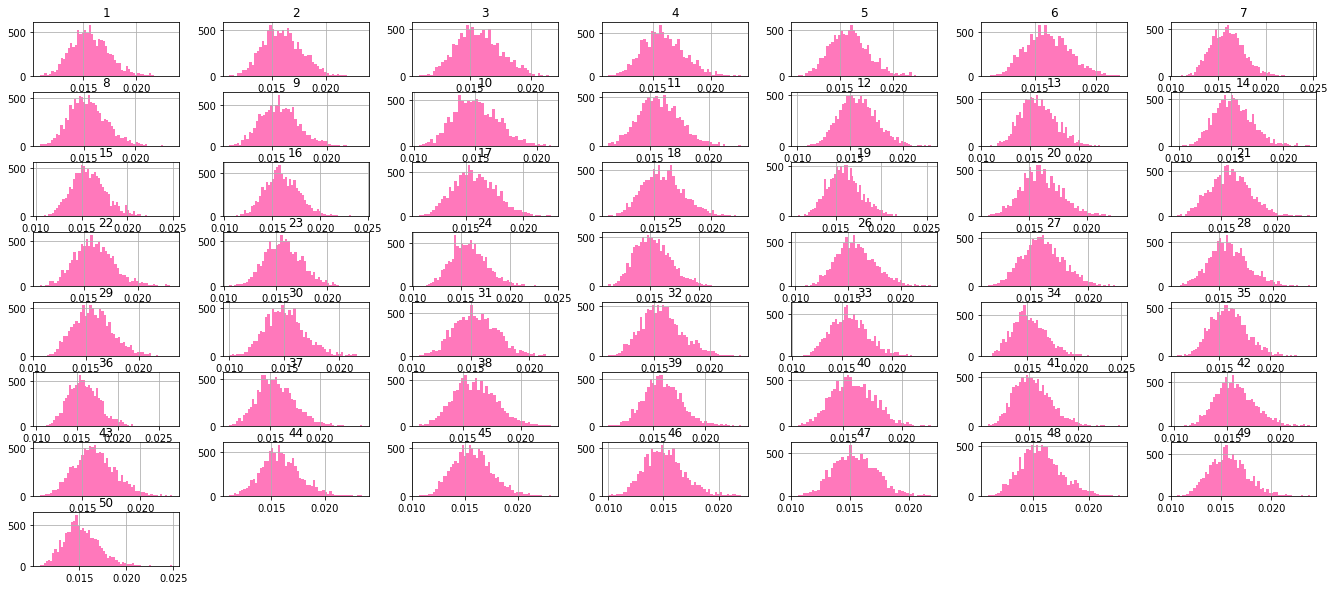

In [8]:
permutation_distributions.hist(alpha=0.9, color="hotpink", bins="auto", figsize=(23, 10));

In [9]:
original_statistics = nmi_wrapper(mickey.spikes, z_coords)
original_statistics = original_statistics.to_dict()

for neuron, original_stat in original_statistics.items():
    p_value = Resampler.p_value(original_stat, permutation_distributions[neuron])
    if p_value < 0.05:
        print("neuron {}: p<{}".format(neuron, p_value))

neuron 10: p<0.0364


/anaconda3/envs/pvsnp_env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [10]:
for neuron, original_stat in original_statistics.items():
    result = Resampler.two_tailed_test(original_stat, permutation_distributions[neuron])
    print("neuron {}: result={}".format(neuron, result))

neuron 1: result=0
neuron 2: result=0
neuron 3: result=0
neuron 4: result=0
neuron 5: result=-1
neuron 6: result=0
neuron 7: result=0
neuron 8: result=0
neuron 9: result=0
neuron 10: result=1
neuron 11: result=0
neuron 12: result=0
neuron 13: result=0
neuron 14: result=0
neuron 15: result=0
neuron 16: result=0
neuron 17: result=0
neuron 18: result=-1
neuron 19: result=0
neuron 20: result=0
neuron 21: result=0
neuron 22: result=0
neuron 23: result=0
neuron 24: result=0
neuron 25: result=0
neuron 26: result=0
neuron 27: result=0
neuron 28: result=0
neuron 29: result=0
neuron 30: result=0
neuron 31: result=-1
neuron 32: result=0
neuron 33: result=0
neuron 34: result=0
neuron 35: result=0
neuron 36: result=0
neuron 37: result=0
neuron 38: result=0
neuron 39: result=0
neuron 40: result=0
neuron 41: result=0
neuron 42: result=0
neuron 43: result=0
neuron 44: result=0
neuron 45: result=0
neuron 46: result=0
neuron 47: result=-1
neuron 48: result=0
neuron 49: result=0
neuron 50: result=0


## Cell Selectivity

#### Use the `shuffle` function in order to create a permutation distribution, for each neuron, of the difference of mean rates.

In [11]:
%time permutation_distr = Resampler.shuffle(mickey.spikes, Resampler.diff_of_mean_rate, mickey.spikes_and_beh["OpenArms"], mickey.spikes_and_beh["ClosedArms"])

CPU times: user 17.5 ms, sys: 28.1 ms, total: 45.7 ms
Wall time: 9.57 s


#### Plot the permutation distributions

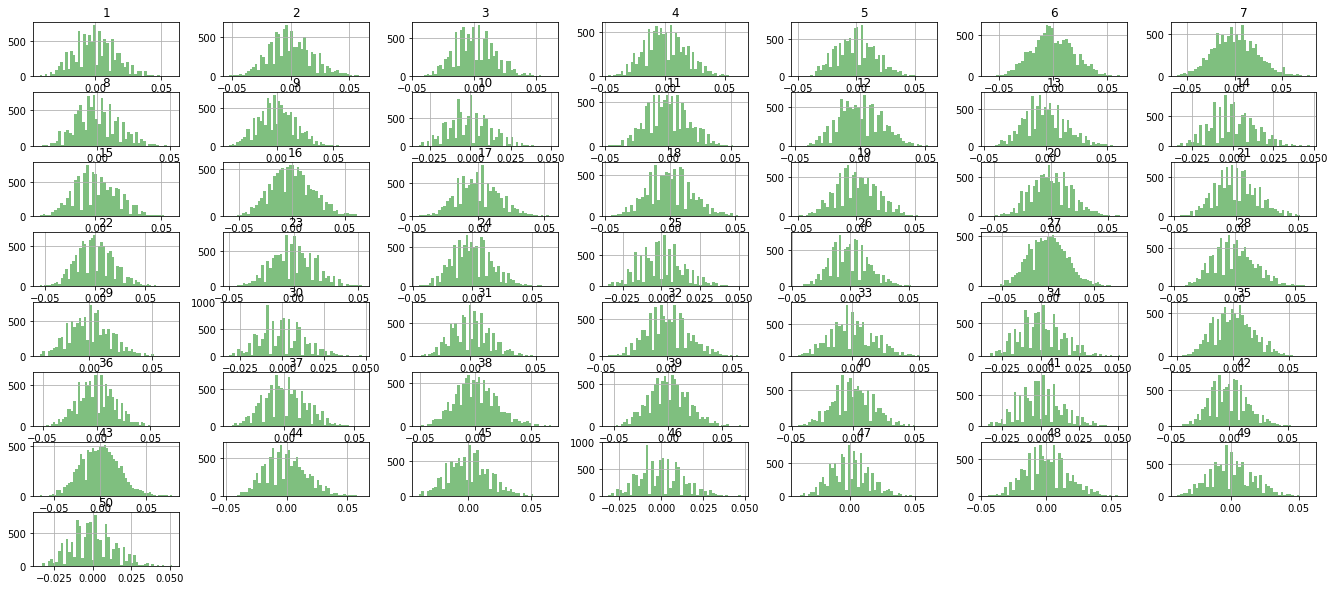

In [12]:
permutation_distr.hist(alpha=0.5, color="green", bins="auto", figsize=(23, 10));

#### Classify cells by the behavior for which they are selective.

In [13]:
original_diff_of_means = dict(zip(mickey.spikes.columns, Resampler.diff_of_mean_rate(mickey.spikes, mickey.spikes_and_beh["OpenArms"], mickey.spikes_and_beh["ClosedArms"])))

p_values = {}
for neuron, original_stat in original_diff_of_means.items():
    p_value = Resampler.p_value(original_diff_of_means[neuron], permutation_distr[neuron])
    p_values[neuron] = p_value
    print("neuron {}: p={}".format(neuron, p_value))

neuron 1: p=0.378
neuron 2: p=0.6676000000000001
neuron 3: p=0.1772
neuron 4: p=0.8308000000000001
neuron 5: p=0.5764
neuron 6: p=0.5512
neuron 7: p=0.6572
neuron 8: p=0.6788000000000001
neuron 9: p=0.4948
neuron 10: p=0.9832000000000001
neuron 11: p=0.6048
neuron 12: p=0.8572000000000001
neuron 13: p=0.1704
neuron 14: p=0.098
neuron 15: p=0.061200000000000004
neuron 16: p=0.202
neuron 17: p=1.0
neuron 18: p=0.2424
neuron 19: p=0.3304
neuron 20: p=1.0
neuron 21: p=0.0364
neuron 22: p=0.10200000000000001
neuron 23: p=0.9628000000000001
neuron 24: p=0.8216
neuron 25: p=0.5024000000000001
neuron 26: p=0.2948
neuron 27: p=0.40800000000000003
neuron 28: p=0.7152000000000001
neuron 29: p=0.622
neuron 30: p=0.6256
neuron 31: p=0.6032000000000001
neuron 32: p=0.5208
neuron 33: p=0.0028
neuron 34: p=0.8596
neuron 35: p=0.4924
neuron 36: p=0.3004
neuron 37: p=0.07440000000000001
neuron 38: p=0.5244
neuron 39: p=0.17880000000000001
neuron 40: p=0.7268
neuron 41: p=0.5024000000000001
neuron 42: p=

In [14]:
classified_cells = {}

for neuron, p_value in p_values.items():
    if p_value < 0.05 and original_diff_of_means[neuron] > 0:
        classified_cells[neuron] = "OpenArms_centerpoint"
    elif p_value < 0.05 and original_diff_of_means[neuron] < 0:
        classified_cells[neuron] = "ClosedArms_centerpoint"
    elif p_value >= 0.05:
        classified_cells[neuron] = "Not-selective"
        
print(classified_cells)

{1: 'Not-selective', 2: 'Not-selective', 3: 'Not-selective', 4: 'Not-selective', 5: 'Not-selective', 6: 'Not-selective', 7: 'Not-selective', 8: 'Not-selective', 9: 'Not-selective', 10: 'Not-selective', 11: 'Not-selective', 12: 'Not-selective', 13: 'Not-selective', 14: 'Not-selective', 15: 'Not-selective', 16: 'Not-selective', 17: 'Not-selective', 18: 'Not-selective', 19: 'Not-selective', 20: 'Not-selective', 21: 'ClosedArms_centerpoint', 22: 'Not-selective', 23: 'Not-selective', 24: 'Not-selective', 25: 'Not-selective', 26: 'Not-selective', 27: 'Not-selective', 28: 'Not-selective', 29: 'Not-selective', 30: 'Not-selective', 31: 'Not-selective', 32: 'Not-selective', 33: 'ClosedArms_centerpoint', 34: 'Not-selective', 35: 'Not-selective', 36: 'Not-selective', 37: 'Not-selective', 38: 'Not-selective', 39: 'Not-selective', 40: 'Not-selective', 41: 'Not-selective', 42: 'Not-selective', 43: 'Not-selective', 44: 'Not-selective', 45: 'Not-selective', 46: 'Not-selective', 47: 'Not-selective', 48:

#### Plot a pie chart in order to visualize the proportions of cells that are selective for behaviors of interest.

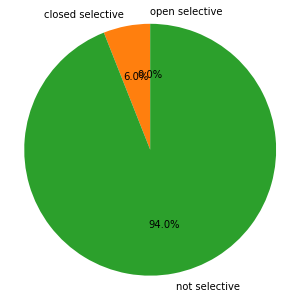

In [15]:
open_selective = 0
closed_selective = 0
not_seletive = 0

for cell, classification in classified_cells.items():
    if classification == "OpenArms_centerpoint":
        open_selective += 1
    elif classification == "ClosedArms_centerpoint":
        closed_selective += 1
    elif classification == "Not-selective":
        not_seletive += 1
        
# Plot a pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = [open_selective, closed_selective, not_seletive]
visualize.pie_chart(sizes, "open selective", "closed selective", "not selective")

## Clustering

In [16]:
all_behavior_intervals = []

for behavior in ["OpenArms", "ClosedArms", "Center"]:
    epochs = au.extract_epochs(mickey, behavior)
    behavior_intervals = au.filter_epochs(epochs[1], framerate=1, seconds=1)
    all_behavior_intervals.append(behavior_intervals)

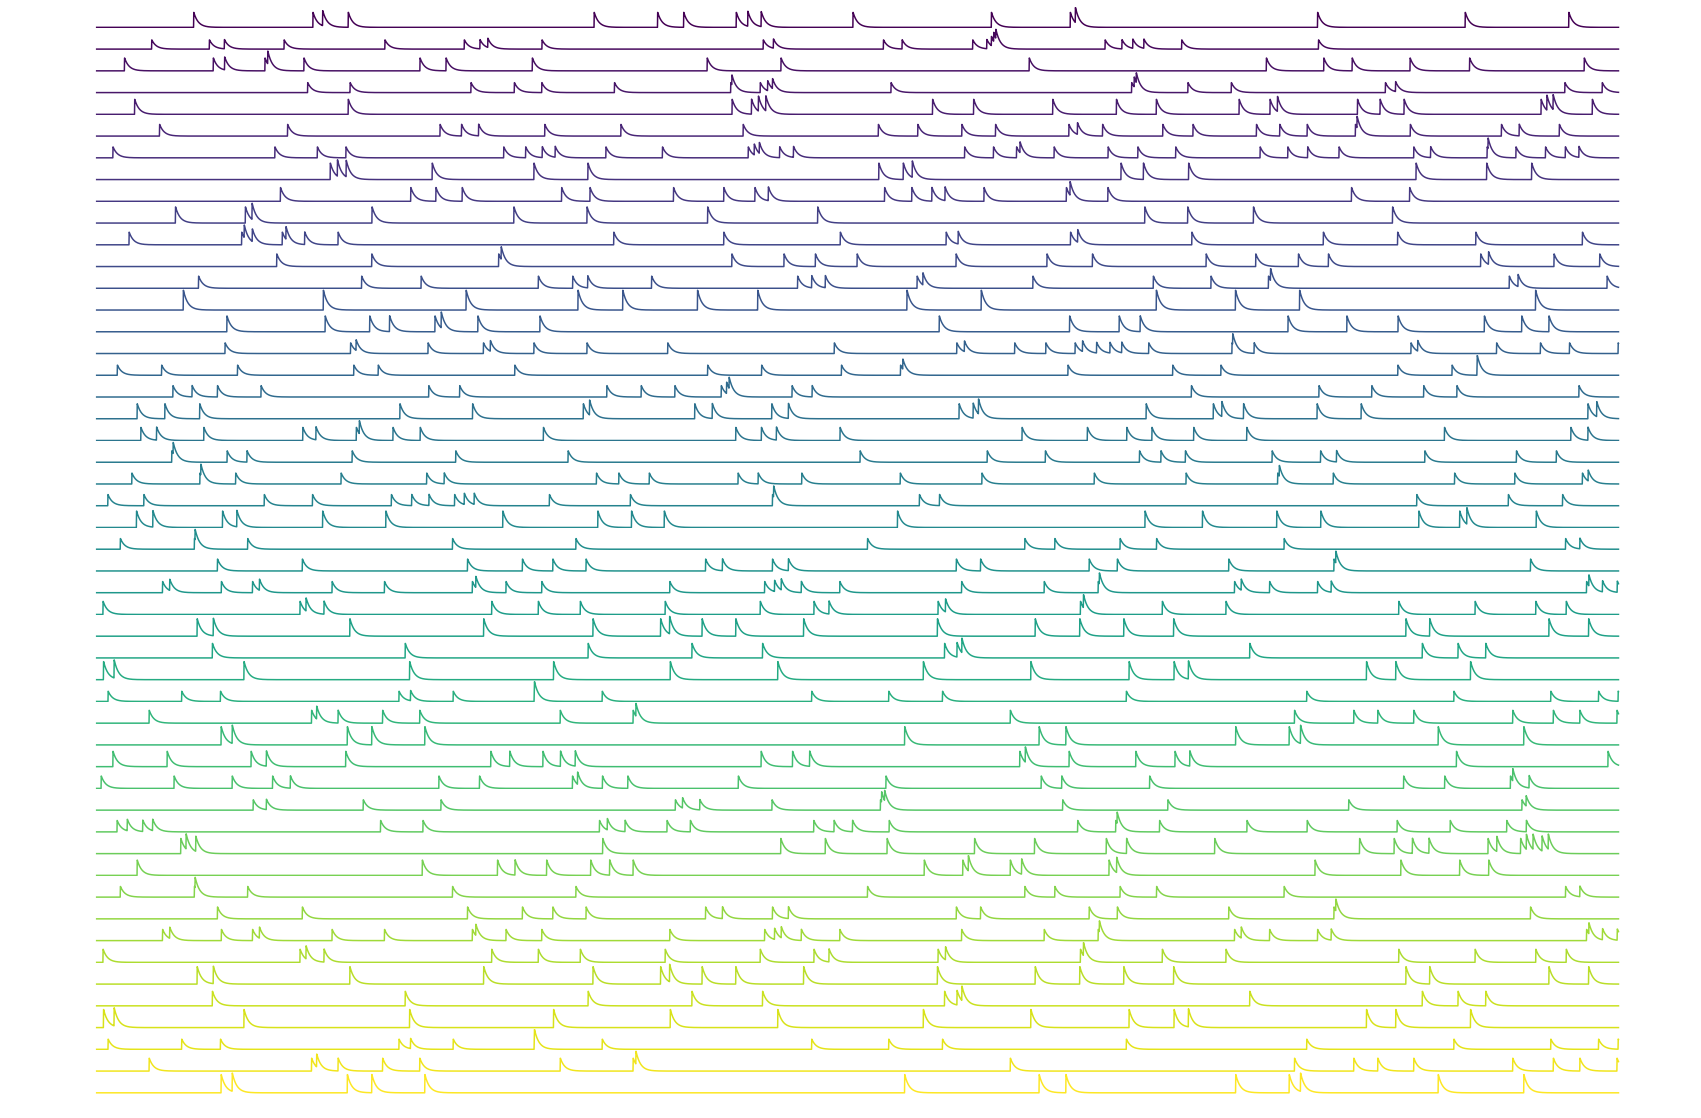

In [17]:
visualize.ts_plot(mickey.cell_transients, figsize=(30, 20), savefig=False)

#### We find all possible clusters of neurons during the overall session. 

#### Compute a similarity matrix using normalized mutual information as the similarity measure.

In [18]:
sim_matrix = clustering.similarity_matrix(mickey.spikes)
clusters = clustering.affinity_propagation(sim_matrix)

#### Affinity Propagation created the following clusters:

In [19]:
clustering.extract_clusters(clusters)

defaultdict(list,
            {0: [1],
             1: [2],
             2: [3],
             3: [4],
             4: [5],
             5: [7],
             6: [8],
             7: [9],
             8: [10],
             9: [11],
             10: [12],
             11: [14],
             12: [15],
             13: [16],
             14: [17],
             15: [18],
             16: [19],
             17: [20],
             18: [21],
             19: [22],
             20: [23],
             21: [24],
             22: [31, 47],
             23: [32, 48],
             24: [35],
             25: [36],
             26: [37],
             27: [6, 38],
             28: [13, 39],
             29: [40],
             30: [25, 41],
             31: [26, 42],
             32: [27, 43],
             33: [28, 44],
             34: [29, 45],
             35: [30, 46],
             36: [33, 49],
             37: [34, 50]})

## Graph Theoretical Analysis

#### Compute the functional connectivity between every pair of neurons using normalized mutual information

In [20]:
connections = clustering.compute_connections(mickey.spikes)

/anaconda3/envs/pvsnp_env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


#### Create a `NeuronNetwork` object using the names of the columns (traces) as the nodes, and the connections we computed above as the weighted edges. 

In [21]:
neuron_network = NeuronNetwork(mickey.spikes.columns, connections)

#### We plot the neuron network.  Each node (neuron) is color coded by its respective cluster and edges are colored by their respective weights.

A neuron position dictionary was not provided! The spring_layout function will be used to plot the network.
/anaconda3/envs/pvsnp_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


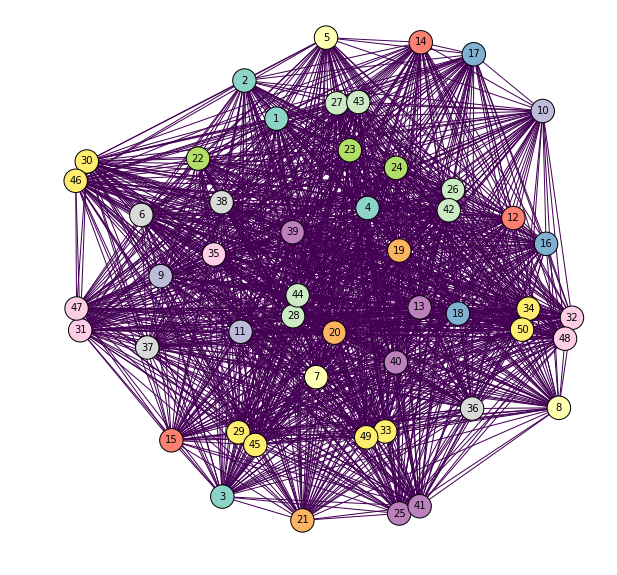

In [22]:
node_colors = [cluster for node, cluster in sorted(clusters.items())]

_, weights = zip(*nx.get_edge_attributes(neuron_network.network, "weight").items())

_ = neuron_network.plot(node_color=node_colors, cmap=plt.cm.Set3, figsize=(10, 10), node_size=550, edge_color=weights, edge_cmap=plt.cm.viridis, savefig=True)

#### Compute the mean betweeness centrality of the neuron network.

In [23]:
neuron_network.mean_betw_cent()

0.0013435374149659862

#### Compute the average clustering coefficient of the network of neurons.

In [24]:
nx.average_clustering(neuron_network.network, weight="weight")

0.0007999923679942252

#### Compute the average clustering coefficient for each extracted cluster.

In [25]:
# Get the clusters into a <cluster-label: nodes-list> format
extracted_clusters = clustering.extract_clusters(clusters)

for _, cluster in extracted_clusters.items():
    avg_cluster_coeff = np.mean(list(nx.clustering(neuron_network.network, weight="weight", nodes=cluster).values()))
    print("avg clustering coefficient of {} = {}".format(cluster, avg_cluster_coeff))    

avg clustering coefficient of [1] = 0.0008003705822343997
avg clustering coefficient of [2] = 0.0006599326630204492
avg clustering coefficient of [3] = 0.0006482575852636907
avg clustering coefficient of [4] = 0.0010189094124008653
avg clustering coefficient of [5] = 0.0006364097042351135
avg clustering coefficient of [7] = 0.0008649717576091223
avg clustering coefficient of [8] = 0.0005202265734247253
avg clustering coefficient of [9] = 0.0006226204879744952
avg clustering coefficient of [10] = 0.0005338131137881944
avg clustering coefficient of [11] = 0.0008071983444449596
avg clustering coefficient of [12] = 0.0007297397246526158
avg clustering coefficient of [14] = 0.0004993770213905378
avg clustering coefficient of [15] = 0.0006482575852636907
avg clustering coefficient of [16] = 0.0008038965322332483
avg clustering coefficient of [17] = 0.0005606755961052972
avg clustering coefficient of [18] = 0.0007051556263825259
avg clustering coefficient of [19] = 0.0007730382225581692
avg c

#### We the compute the degree assortativity of the neuron network.

In [26]:
nx.degree_pearson_correlation_coefficient(neuron_network.network, weight="weight")

-0.020408163265306128